In [1]:
from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA, FastICA
from sklearn import manifold
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold

from umap import UMAP

c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\users\weldl\miniconda3\envs\i2a2-fm\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Loading the data file:
data = pd.read_excel('../data/readcounts.xlsx')
data

,Unnamed: 0,H223,H224,H225,H226,H227,H228,H229,H230,H231,...,H261,H262,H263,H264,H265,H266,H267,H268,H269,H270
0,ENSG00000000003,0,0,0,1,0,0,0,0,1,...,0,1,0,1,0,2,0,0,1,0
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,1216,1228,1022,912,491,449,466,727,774,...,980,932,360,450,484,926,803,630,537,582
3,ENSG00000000457,189,114,110,289,186,148,169,258,145,...,117,286,137,90,105,275,101,56,87,81
4,ENSG00000000460,74,38,55,127,30,17,45,100,33,...,28,157,34,20,15,139,54,25,21,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65210,ENSG00000281918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65211,ENSG00000281919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65212,ENSG00000281920,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65213,ENSG00000281921,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Transposing the data:
columns = data.loc[:, 'Unnamed: 0'].values
data = data.drop(columns=['Unnamed: 0'])
data = data.transpose()
data.columns = columns
data

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281913,ENSG00000281914,ENSG00000281915,ENSG00000281916,ENSG00000281917,ENSG00000281918,ENSG00000281919,ENSG00000281920,ENSG00000281921,ENSG00000281922
H223,0,0,1216,189,74,31895,2,763,8963,1589,...,0,0,0,0,0,0,0,0,0,0
H224,0,0,1228,114,38,23361,3,712,26794,1734,...,0,0,0,0,0,0,0,0,0,0
H225,0,0,1022,110,55,27944,0,956,8027,1341,...,0,0,0,0,0,0,0,0,0,0
H226,1,0,912,289,127,41846,6,1104,716,1053,...,0,0,0,0,0,0,0,0,0,0
H227,0,0,491,186,30,11929,14,136,745,730,...,0,0,0,0,0,0,0,0,0,0
H228,0,0,449,148,17,6856,16,227,3770,663,...,0,0,0,0,0,0,0,0,0,0
H229,0,0,466,169,45,6756,15,217,1260,669,...,0,0,0,0,0,0,0,0,0,0
H230,0,0,727,258,100,7668,4,905,1480,883,...,0,0,0,0,0,0,0,0,0,0
H231,1,0,774,145,33,9315,1,94,75,873,...,0,0,0,0,0,0,0,0,0,0
H232,0,0,576,131,8,3319,7,88,288,678,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, H223 to H270
Columns: 65215 entries, ENSG00000000003 to ENSG00000281922
dtypes: int64(65215)
memory usage: 23.9+ MB


In [5]:
data_descr = data.describe().transpose()
data_descr

,count,mean,std,min,25%,50%,75%,max
ENSG00000000003,48.0,0.250000,0.525924,0.0,0.00,0.0,0.0,2.0
ENSG00000000005,48.0,0.041667,0.201941,0.0,0.00,0.0,0.0,1.0
ENSG00000000419,48.0,709.125000,224.728453,318.0,540.75,686.0,884.0,1228.0
ENSG00000000457,48.0,136.395833,62.975760,56.0,90.00,114.5,157.0,289.0
ENSG00000000460,48.0,44.916667,35.518550,7.0,21.00,31.5,54.0,157.0
...,...,...,...,...,...,...,...,...
ENSG00000281918,48.0,0.041667,0.201941,0.0,0.00,0.0,0.0,1.0
ENSG00000281919,48.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
ENSG00000281920,48.0,0.020833,0.144338,0.0,0.00,0.0,0.0,1.0
ENSG00000281921,48.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0


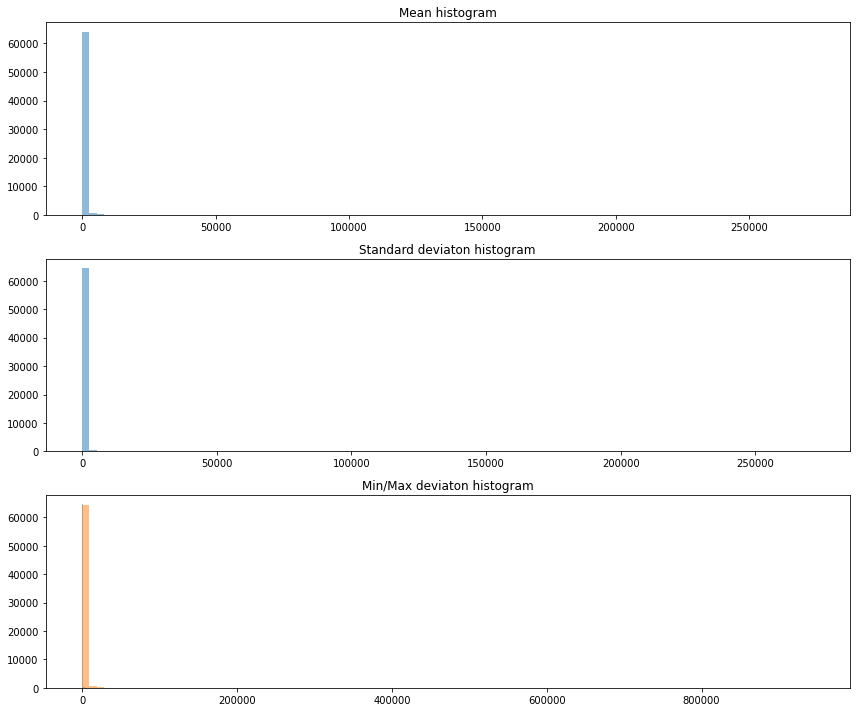

mean: 0.0 273854.9375
std: 0.0 271497.3182218875
min: 0.0 112853.0
max: 0.0 944074.0


In [6]:
def plot_features_desc(data_descr):
    plt.figure(figsize=(12, 10))
    plt.subplot(3,1,1)
    plt.title('Mean histogram')
    plt.hist(data_descr['mean'], alpha=0.5, bins=100)
    plt.subplot(3,1,2)
    plt.title('Standard deviaton histogram')
    plt.hist(data_descr['std'], alpha=0.5, bins=100)
    plt.subplot(3,1,3)
    plt.title('Min/Max deviaton histogram')
    plt.hist(data_descr['min'], alpha=0.5, bins=100)
    plt.hist(data_descr['max'], alpha=0.5, bins=100)
    plt.tight_layout()
    plt.show()

    print('mean:', data_descr['mean'].min(), data_descr['mean'].max())
    print('std:', data_descr['std'].min(), data_descr['std'].max())
    print('min:', data_descr['min'].min(), data_descr['min'].max())
    print('max:', data_descr['max'].min(), data_descr['max'].max())

plot_features_desc(data_descr)

In [7]:
zero_std_cols = list(data_descr[data_descr['std'] <= 0].index)
print(f'{len(zero_std_cols)} columns have standard deviation = 0')

20537 columns have standard deviation = 0


In [8]:
data_descr_gzero = data_descr.loc[~np.isin(data_descr.index, zero_std_cols), :]
data_descr_gzero

,count,mean,std,min,25%,50%,75%,max
ENSG00000000003,48.0,0.250000,0.525924,0.0,0.00,0.0,0.0,2.0
ENSG00000000005,48.0,0.041667,0.201941,0.0,0.00,0.0,0.0,1.0
ENSG00000000419,48.0,709.125000,224.728453,318.0,540.75,686.0,884.0,1228.0
ENSG00000000457,48.0,136.395833,62.975760,56.0,90.00,114.5,157.0,289.0
ENSG00000000460,48.0,44.916667,35.518550,7.0,21.00,31.5,54.0,157.0
...,...,...,...,...,...,...,...,...
ENSG00000281904,48.0,0.020833,0.144338,0.0,0.00,0.0,0.0,1.0
ENSG00000281909,48.0,0.145833,0.651988,0.0,0.00,0.0,0.0,4.0
ENSG00000281912,48.0,1.020833,1.193771,0.0,0.00,1.0,2.0,5.0
ENSG00000281918,48.0,0.041667,0.201941,0.0,0.00,0.0,0.0,1.0


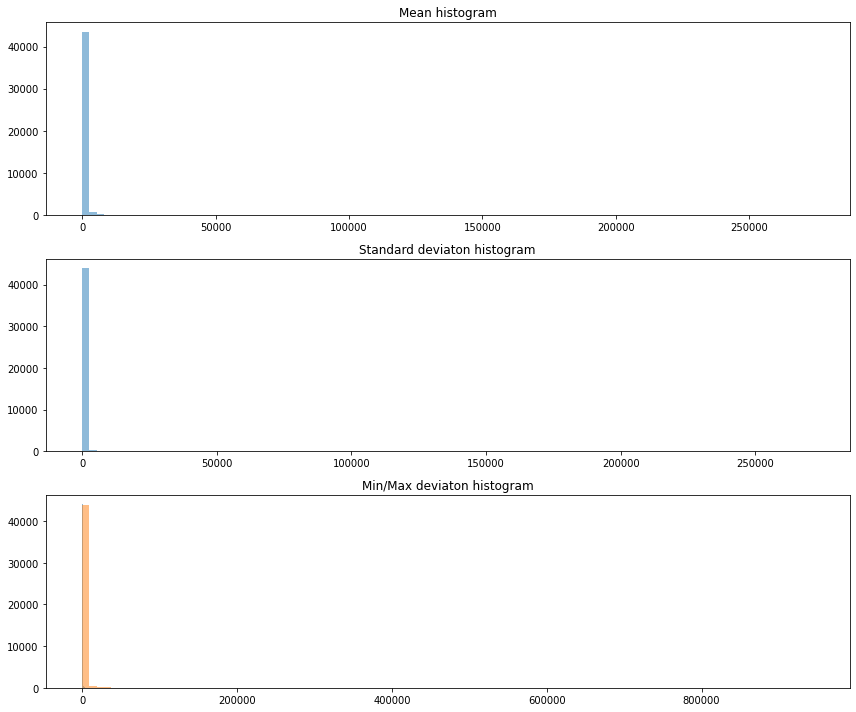

mean: 0.020833333333333332 273854.9375
std: 0.14433756729740643 271497.3182218875
min: 0.0 112853.0
max: 1.0 944074.0


In [9]:
plot_features_desc(data_descr_gzero)

## Preprocessing

In [10]:
X_array = data.loc[:, data.columns].values
X_array.shape

(48, 65215)

In [11]:
# Feature seletion:
sel = VarianceThreshold(threshold=0)
X_array_sel = sel.fit_transform(X_array)
X_array_sel.shape

(48, 44678)

In [ ]:
# Normalizing data:
x_array_norm = MinMaxScaler().fit_transform(X_array_sel)
pd.DataFrame(x_array_norm)

In [ ]:
# Standardizing data:
x_array_std = StandardScaler().fit_transform(X_array_sel)
pd.DataFrame(x_array_std)

# Embeddings:

In [14]:
def plot_3d(x_array, title=''):
    fig = plt.figure(figsize=(10, 87))
    ax = fig.add_subplot(111, projection='3d')
    plt.title(title)
    ax.scatter(x_array[:, 0], x_array[:, 1], x_array[:, 2], alpha=0.5)

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    plt.tight_layout()
    plt.show()

In [15]:
n_components = 3
n_neighbors = 10

In [16]:
# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding, n_neighbors=n_neighbors,
              n_components=n_components, eigen_solver='auto')


methods = OrderedDict()
methods['PCA'] = PCA(n_components=n_components)
methods['FastICA'] = PCA(n_components=n_components)
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components)
methods['MDS'] = manifold.MDS(n_components=n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)
methods['UMAP'] = UMAP(n_components=n_components, init='random', random_state=0)

In [17]:
# Summary of all Ensemble methods:

def plot_ensembles(x_array: np.ndarray):
    fig = plt.figure(figsize=(18, 24))
    # Plot results
    for i, (label, method) in enumerate(methods.items()):
        t0 = time()
        x_embedded = method.fit_transform(x_array)
        t1 = time()
        print("%s: %.2g sec" % (label, t1 - t0))

        ax = fig.add_subplot(4, 3, i+1, projection='3d')
        ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
        ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], alpha=0.5, s=50, cmap=plt.cm.Spectral)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')    
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
    plt.tight_layout()
    plt.show()

PCA: 0.22 sec
FastICA: 0.12 sec
LLE: 0.44 sec
LTSA: 0.38 sec
Hessian LLE: 0.36 sec
Modified LLE: 0.5 sec
Isomap: 0.024 sec
MDS: 0.03 sec
SE: 0.017 sec
t-SNE: 0.16 sec
UMAP: 5.2 sec


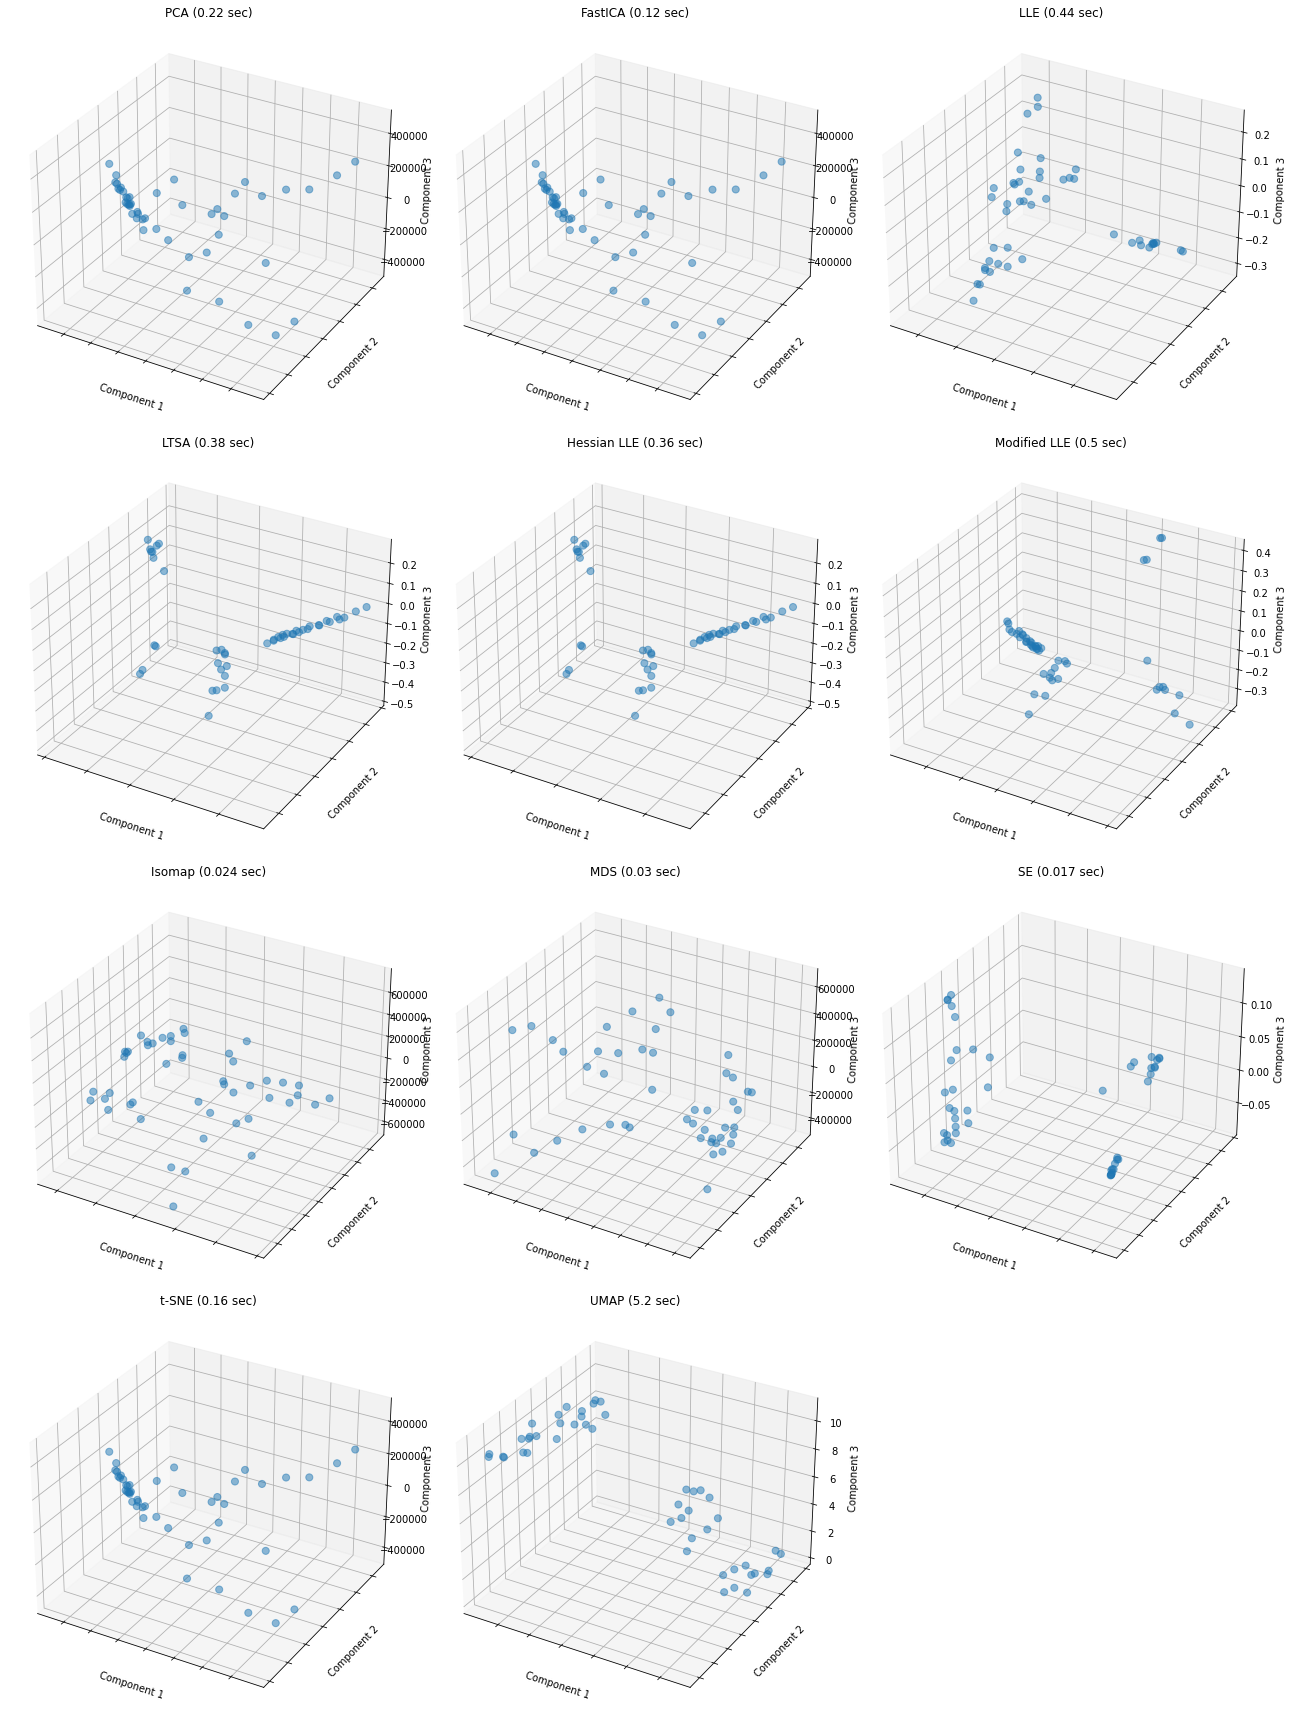

In [18]:
plot_ensembles(X_array_sel)

PCA: 0.17 sec
FastICA: 0.13 sec
LLE: 0.41 sec
LTSA: 0.32 sec
Hessian LLE: 0.37 sec
Modified LLE: 0.48 sec
Isomap: 0.011 sec
MDS: 0.028 sec
SE: 0.017 sec
t-SNE: 0.45 sec
UMAP: 0.8 sec


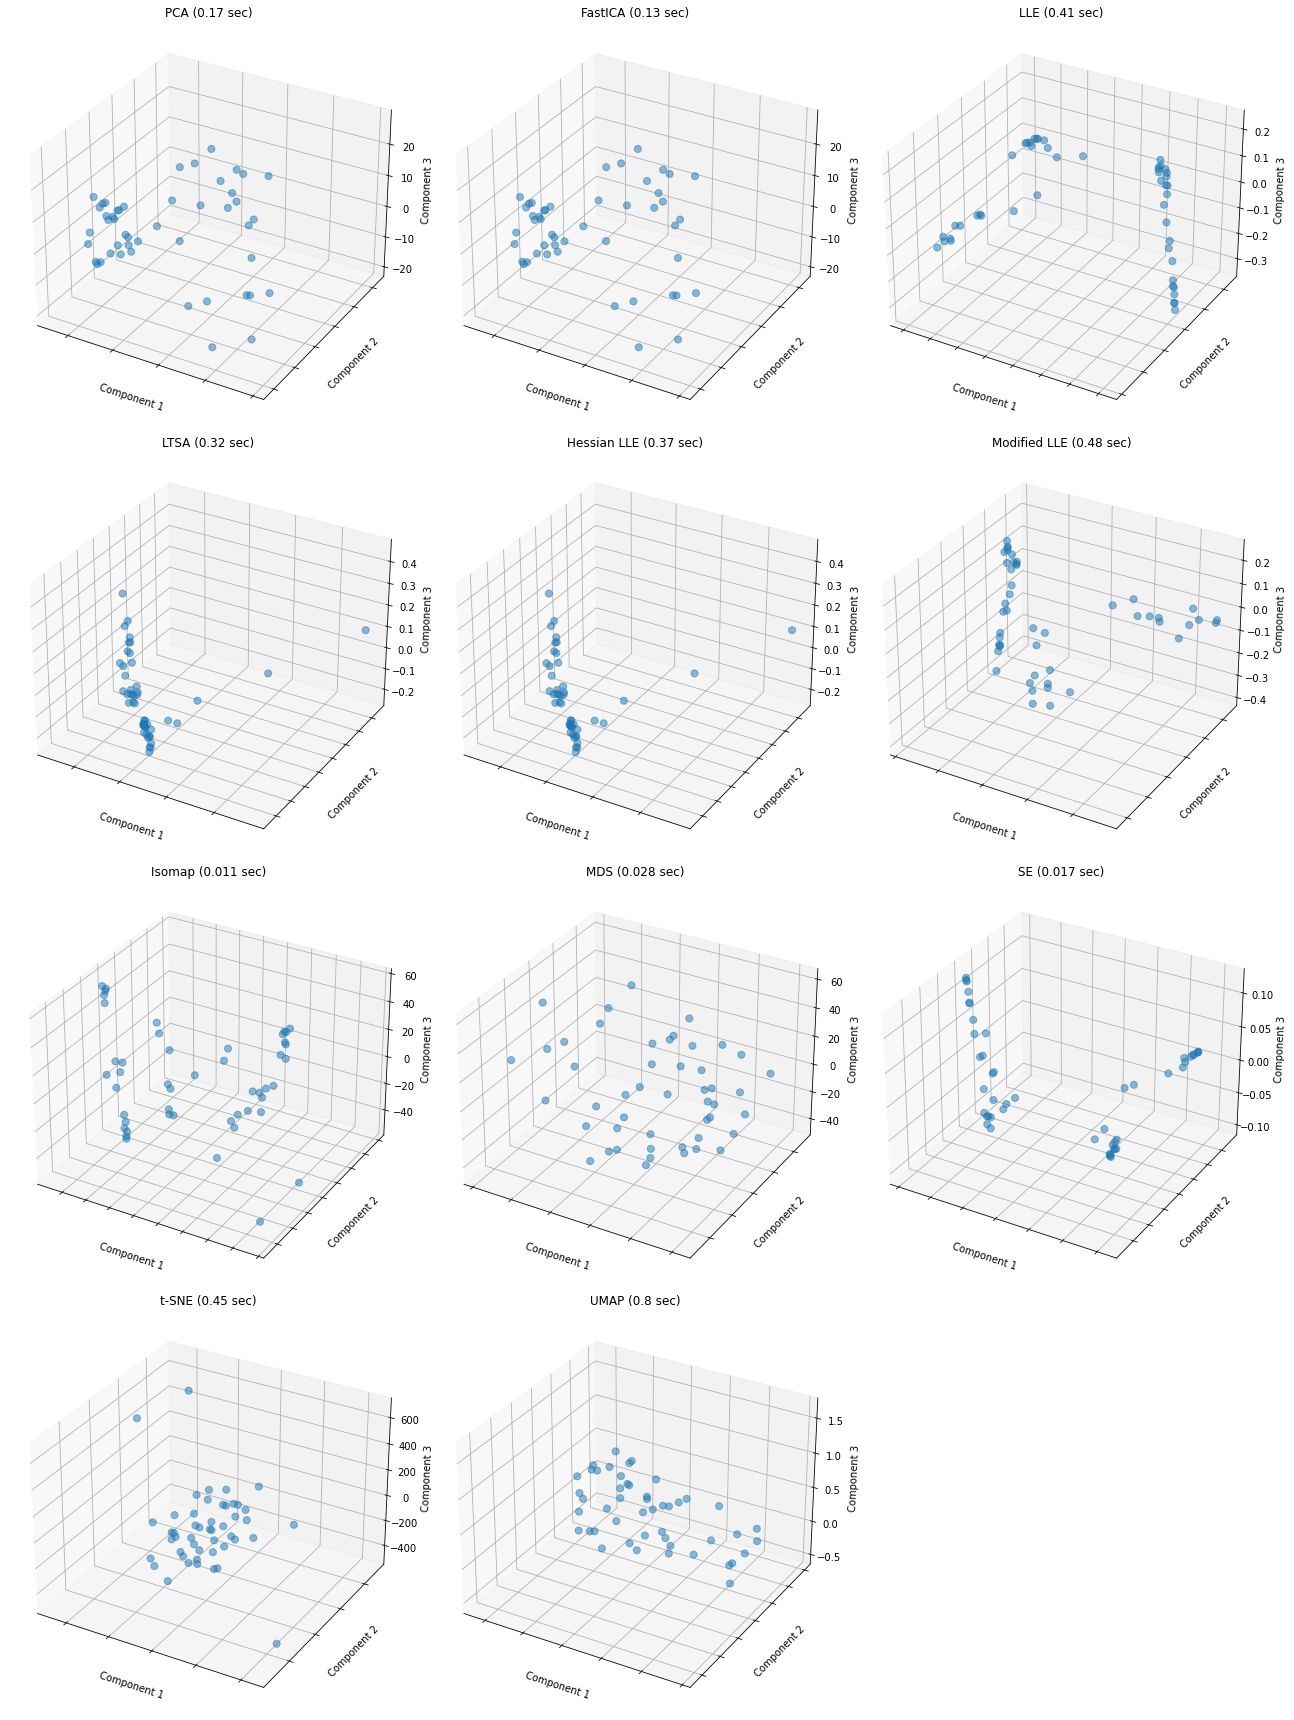

In [19]:
plot_ensembles(x_array_norm)

PCA: 0.14 sec
FastICA: 0.13 sec
LLE: 0.36 sec
LTSA: 0.3 sec
Hessian LLE: 0.31 sec
Modified LLE: 0.44 sec
Isomap: 0.011 sec
MDS: 0.028 sec
SE: 0.016 sec
t-SNE: 0.41 sec
UMAP: 0.84 sec


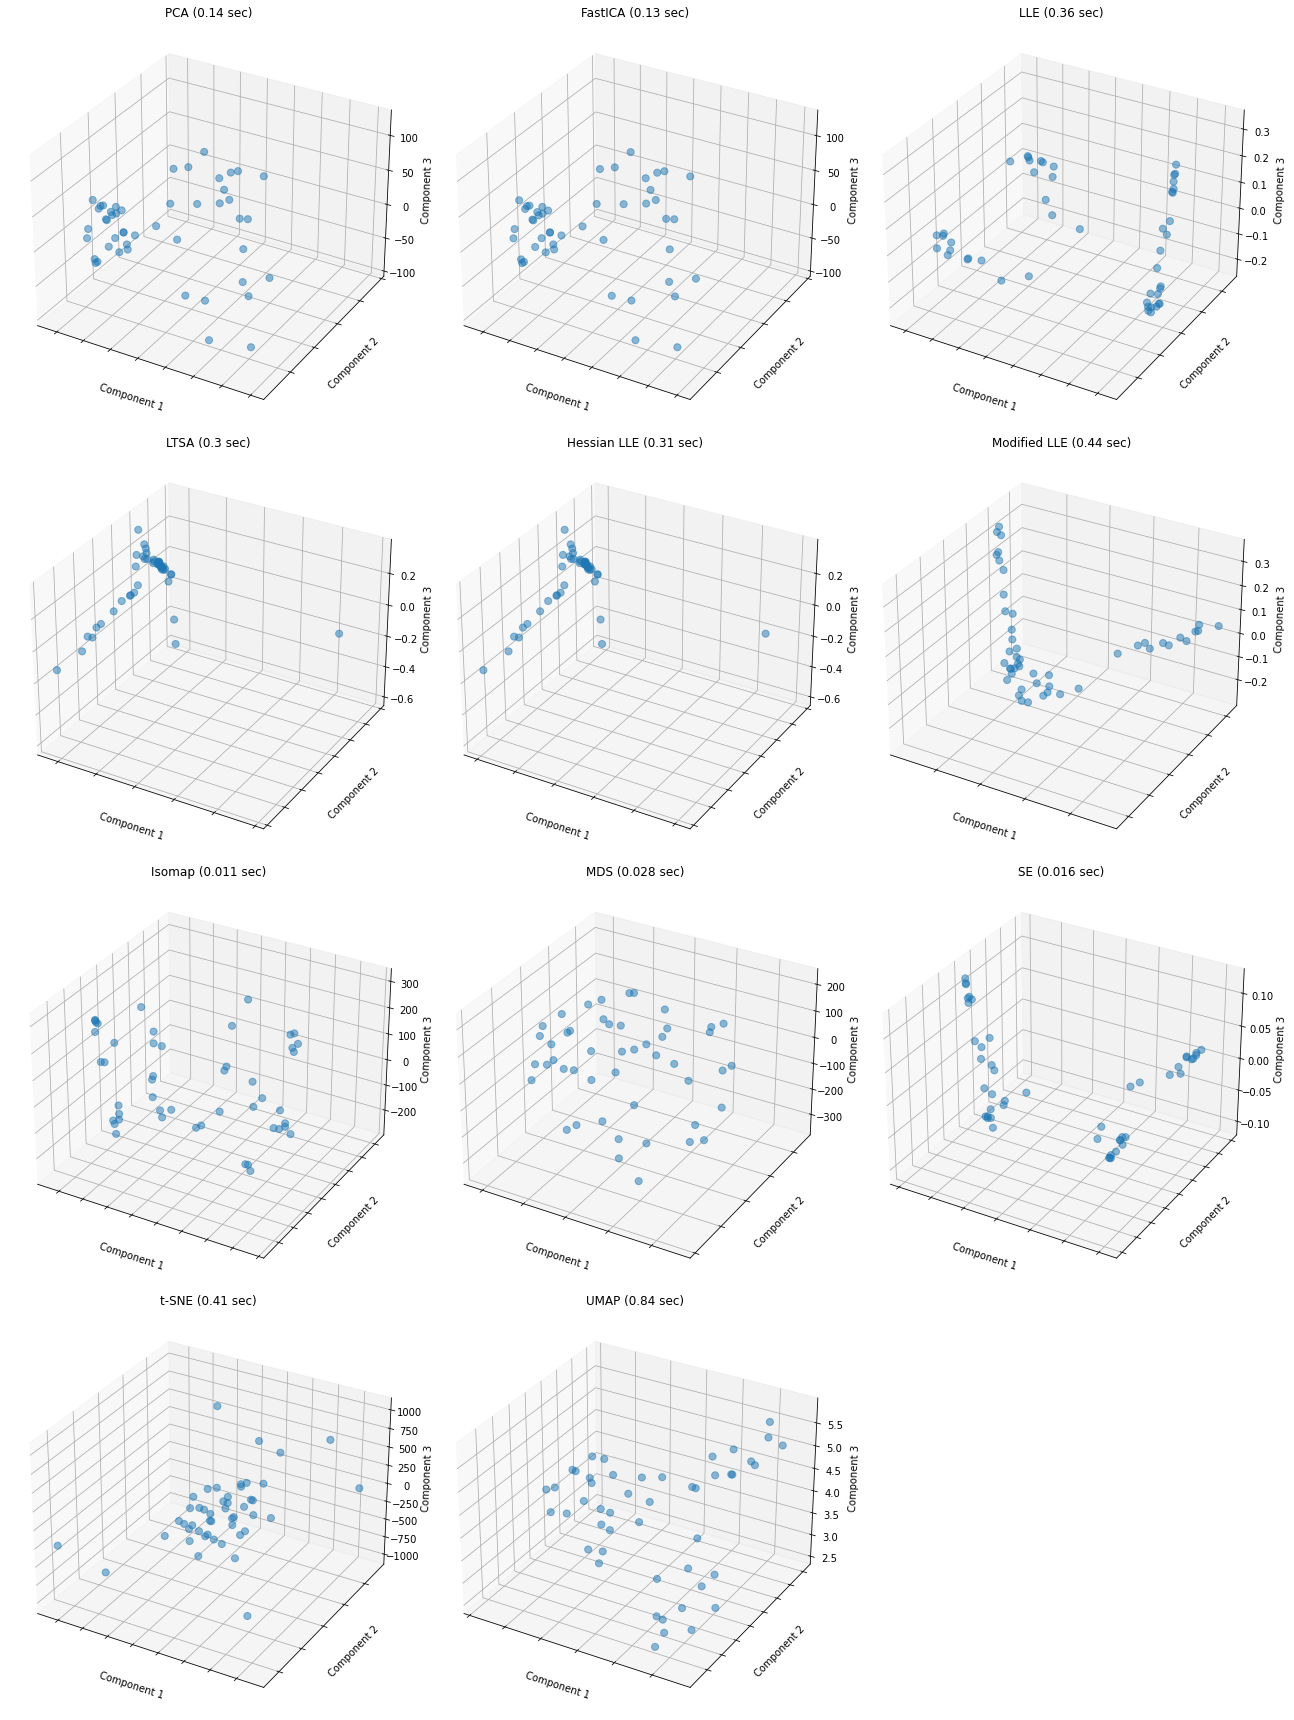

In [20]:
plot_ensembles(x_array_std)